# This is a notebook for querying the merged TS instance for the 1.0.0 Beacon release.

- You can run each cell individually by pressing "shift + enter".
- For more information, questions, bugs, please contact us on Slack:
  - https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.


#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.


In [ ]:
Token = " "

#### Install the following packages, if you have not already installed them in your environment:

- pip install requests
- pip install xarray
- pip install ipywidgets
- pip install cartopy
- pip install h5netcdf
- pip install netcdf4
- pip install scipy
- pip install packaging


#### Import the required packages


In [2]:
import requests
import json
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#### Retrieve the available columns from the Merged TS endpoint

Swagger page here: https://beacon-wb1-ts.maris.nl/swagger/


In [3]:
responseinfo = requests.get(
    "https://beacon-wb1-ts.maris.nl/api/query/available-columns",
    headers={"Authorization": f"Bearer {Token}"},
)
params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").


In [4]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]

    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")


search_columns("temp")  # Enter your search term here

Matching columns:
Common.Temperature
Common.Temperature.P01
Common.Temperature.P06
Common.Temperature.qf
Common.Temperature.qf_schema
Common.Temperature.standard_name
Common.Temperature.units
Common.Temperature.units.uri
Common.Temperature.uri
TEMP
TEMP.long_name
TEMP.standard_name
TEMP.units
TEMP_ADJUSTED
TEMP_ADJUSTED_QC
TEMP_QC


#### You can define here your input parameters


In [5]:
parameter = "COMMON_TEMPERATURE"  # column name
mindate = "1995-01-01"  # yyyy-mm-dd
maxdate = "1996-04-01"  # yyyy-mm-dd
minlon = -180
maxlon = 180
minlat = -90
maxlat = 90
mindepth = 0
maxdepth = 10

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs.

- For more query examples and explanations, you can take a look at https://github.com/maris-development/beacon-blue-cloud.


In [6]:
def query(
    parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth
):
    body = {
        "query_parameters": [
            {"column_name": parameter, "alias": parameter, "skip_fill_values": True},
            {"column_name": f"{parameter}_UNITS", "alias": "UNIT"},
            {"column_name": "COMMON_TIME", "alias": "datetime"},
            {"column_name": f"{parameter}_QC", "alias": f"{parameter}_QC"},
            {"column_name": f"{parameter}_P01", "alias": f"{parameter}_P01"},
            {"column_name": f"{parameter}_P06", "alias": f"{parameter}_P06"},
            {"column_name": "COMMON_DEPTH", "alias": "COMMON_DEPTH"},
            {"column_name": "COMMON_DEPTH_QC", "alias": "COMMON_DEPTH_QC"},
            {"column_name": "LONGITUDE", "alias": "LONGITUDE"},
            {"column_name": "LATITUDE", "alias": "LATITUDE"},
            {"column_name": "SOURCE_BDI", "alias": "Collection"},
        ],
        "filters": [
            {
                "for_query_parameter": "datetime",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
                "cast": "timestamp",
            },
            {"for_query_parameter": "COMMON_DEPTH", "min": mindepth, "max": maxdepth},
            {"for_query_parameter": "LONGITUDE", "min": minlon, "max": maxlon},
            {"for_query_parameter": "LATITUDE", "min": minlat, "max": maxlat},
        ],
        "output": {"format": "netcdf"},
    }
    return body


query_body = query(
    parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth
)

#### This is the post request that is sent to Beacon with the above specified body.


In [7]:
response = requests.post(
    "https://beacon-wb1-ts.maris.nl/api/query",
    json.dumps(query_body),
    headers={"Authorization": f"Bearer {Token}", "Content-type": "application/json"},
)

if response.status_code == 204:
    print(
        "No data has been found for your query, please update your input fields above and run the notebook again."
    )
elif response.status_code != 200:
    print(response.text)

In [8]:
regionname = f"[{minlat},{minlon}],[{maxlat},{maxlon}]"

if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

open(
    f"./Beacon_V1.0.0_Output/TS_merged_{parameter}_{regionname}_{
        mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc",
    "wb",
).write(response.content)
df = xr.open_dataset(
    f"./Beacon_V1.0.0_Output/TS_merged_{parameter}_{regionname}_{
        mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc"
).to_dataframe()
df = (
    df.assign(datetime=pd.to_datetime(df["datetime"]))
    .set_index("datetime")
    .sort_index()
)
df

,Common.Temperature,Unit,Common.Temperature_qf,Common.Temperature_P01,PRES,LONGITUDE,LATITUDE,Collection,dataset_id
datetime,,,,,,,,,
2010-01-01 00:15:03,23.594999,degree_Celsius,1,SDN::P01::TEMPST01,4.6,-100.681000,-22.337,ARGO,229.0
2010-01-01 00:16:50,7.415000,degree_Celsius,1,SDN::P01::TEMPST01,6.0,175.516000,-55.421,ARGO,361.0
2010-01-01 00:18:42,26.115999,degree_Celsius,1,SDN::P01::TEMPST01,9.5,-122.220001,-20.136,ARGO,80.0
2010-01-01 00:18:42,26.139000,degree_Celsius,1,SDN::P01::TEMPST01,4.6,-122.220001,-20.136,ARGO,80.0
2010-01-01 00:24:57,27.966000,degree_Celsius,1,SDN::P01::TEMPST01,7.4,-119.885002,9.402,ARGO,55.0
...,...,...,...,...,...,...,...,...,...
2010-03-31 23:56:01,27.136000,degree_Celsius,1,SDN::P01::TEMPST01,5.5,-143.361000,-22.453,ARGO,265.0
2010-03-31 23:56:01,26.976000,degree_Celsius,1,SDN::P01::TEMPST01,9.0,-143.361000,-22.453,ARGO,265.0
2010-03-31 23:58:00,15.011000,degree_Celsius,1,SDN::P01::TEMPST01,0.0,4.338000,38.809,ARGO,111.0


#### Optionally apply a filter on your parameter for quick removal of outliers. Note that this can also be achieved within your Beacon request by applying a filter on your parameter.


In [9]:
highbound = 40
lowbound = -2
df = df.loc[(df[f"{parameter}"] < highbound) & (df[f"{parameter}"] > lowbound)]
df

,Common.Temperature,Unit,Common.Temperature_qf,Common.Temperature_P01,PRES,LONGITUDE,LATITUDE,Collection,dataset_id
datetime,,,,,,,,,
2010-01-01 00:15:03,23.594999,degree_Celsius,1,SDN::P01::TEMPST01,4.6,-100.681000,-22.337,ARGO,229.0
2010-01-01 00:16:50,7.415000,degree_Celsius,1,SDN::P01::TEMPST01,6.0,175.516000,-55.421,ARGO,361.0
2010-01-01 00:18:42,26.115999,degree_Celsius,1,SDN::P01::TEMPST01,9.5,-122.220001,-20.136,ARGO,80.0
2010-01-01 00:18:42,26.139000,degree_Celsius,1,SDN::P01::TEMPST01,4.6,-122.220001,-20.136,ARGO,80.0
2010-01-01 00:24:57,27.966000,degree_Celsius,1,SDN::P01::TEMPST01,7.4,-119.885002,9.402,ARGO,55.0
...,...,...,...,...,...,...,...,...,...
2010-03-31 23:56:01,27.136000,degree_Celsius,1,SDN::P01::TEMPST01,5.5,-143.361000,-22.453,ARGO,265.0
2010-03-31 23:56:01,26.976000,degree_Celsius,1,SDN::P01::TEMPST01,9.0,-143.361000,-22.453,ARGO,265.0
2010-03-31 23:58:00,15.011000,degree_Celsius,1,SDN::P01::TEMPST01,0.0,4.338000,38.809,ARGO,111.0


#### Plotting of results.


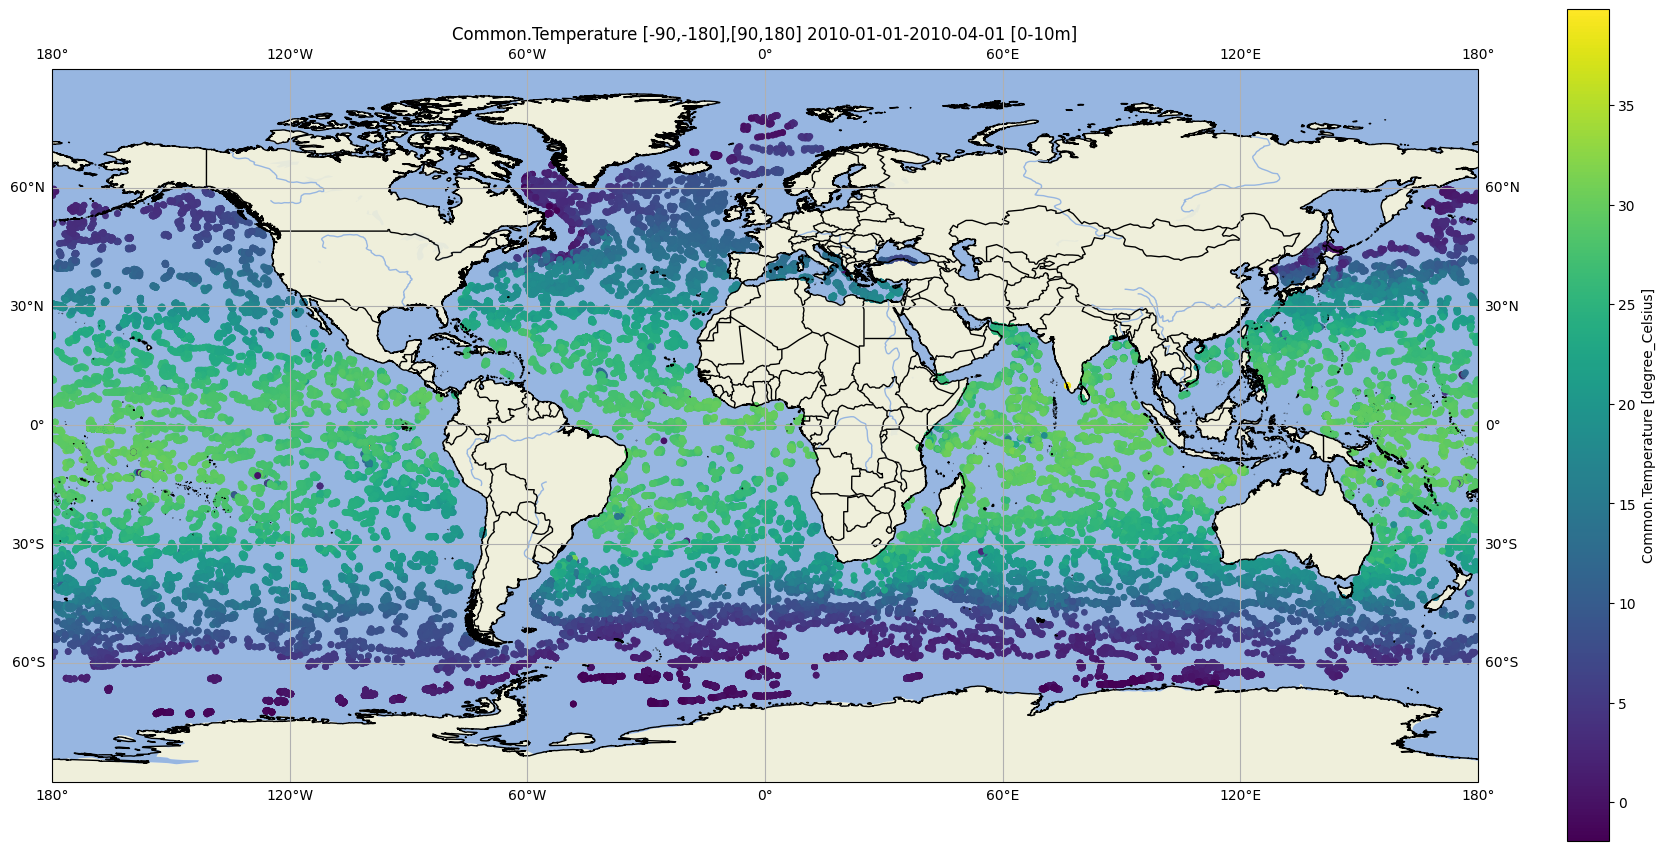

In [10]:
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(
    [-180, 180, -90, 90], crs=ccrs.PlateCarree()
)  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(
    df["LONGITUDE"],
    df["LATITUDE"],
    c=df[parameter],
    cmap="viridis",
    s=15,
    transform=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.1)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{parameter} [{df["Unit"].iloc[0]}]")

plt.title(
    f"{parameter} {regionname} {
        mindate}-{maxdate} [{mindepth}-{maxdepth}m]"
)

plt.show()